In [90]:
import pandas as pd
import numpy as np

from typing import List
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Download data and create sets

In [26]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [27]:
X_test = test_data.copy()

# Exploratory Data Analysis
We are going to check:
- Type of data (categorical, int/float, bounded/unbounded, text, structured, ...)
- Missing values
- Noisiness (outliers, ...)
- Usefulness
- Type of distributions
- Correlations between attributes
- Identify promising transformations

## Type of data

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Initially we can see the following data types per attribute:
- Integer (PassengerId, Survived, Pclass, SibSp, Parch)
- Float (Age, Fare)
- String (Name, Sex, Ticket, Cabin, Embarked)

In [ ]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Survived** is the target value. Also, the **_Age_** attribute is continuous because either when it is less than 1 or it is estimated, it is fractional.  
Some attribute related explanation:
- Survival: Survival (0 = No, 1 = Yes)
- Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- SibSP: Number of siblings or spouses aboard
- Parch: Number of parents or children aboard
- Ticket: Ticket number
- Fare: Passenger fare 
- Cabin: Cabin number
- Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Also, let's check each attribute statistics independently

### Age

In [ ]:
pd.concat([training_data[training_data['Survived'] == 0]['Age'].describe(percentiles=np.arange(0.05, 1, 0.05)),
           training_data[training_data['Survived'] == 1]['Age'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)

,Age,Age
count,424.000000,290.000000
mean,30.626179,28.343690
std,14.172110,14.950952
min,1.000000,0.420000
5%,9.000000,2.450000
10%,16.000000,5.000000
15%,18.000000,14.000000
20%,19.600000,17.000000
25%,21.000000,19.000000
30%,22.000000,21.700000


Let's going to check the _Age_ statistics among survivors and no survivors.  
**No Survivors**:
- The mean age was 30 years old
- The youngest passenger was 1 year old and over 5% of passengers were childs under 9 years.
- 20% of the passengers were teenagers (from 9 to under 21 years)
- 20% were young adults (from 21 to under 27)
- 45% were adults (from 27 to under 50 years)
- 15% were old people (from 50 to 74 years old, which is the maximum)

**Survivors**:
- The mean age was 28 years and the youngest passenger was 0.42 years.
- 15% were under 14 years, being a 5% under 2.45 years
- 15% were from 14 to under 21 years.
- 15% were young adults (from 21 to under 27)
- 40% were adults (from 27 to under 49)
- 15% were old people (from 49 to 80 years, which is the maximum)

So among the survivors there are more number of childs and babies, which makes sense. **We could check if they were from rich families**.

In [ ]:
pd.concat([training_data[(training_data['Survived'] == 0) & (training_data['Age'] < 14)]['Pclass'].describe(percentiles=np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Survived'] == 1) & (training_data['Age'] < 14)]['Pclass'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)
          

,Pclass,Pclass
count,29.000000,42.000000
mean,2.931034,2.428571
std,0.371391,0.630248
min,1.000000,1.000000
5%,3.000000,1.050000
10%,3.000000,2.000000
15%,3.000000,2.000000
20%,3.000000,2.000000
25%,3.000000,2.000000
30%,3.000000,2.000000


Among no survivors, almost all the childs were from poor families, so **they did save first the childs from rich families**.

### SibSp


In [ ]:
pd.concat([training_data[training_data['Survived'] == 0]['SibSp'].describe(percentiles=np.arange(0.05, 1, 0.05)),
           training_data[training_data['Survived'] == 1]['SibSp'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)

,SibSp,SibSp
count,549.000000,342.000000
mean,0.553734,0.473684
std,1.288399,0.708688
min,0.000000,0.000000
5%,0.000000,0.000000
10%,0.000000,0.000000
15%,0.000000,0.000000
20%,0.000000,0.000000
25%,0.000000,0.000000
30%,0.000000,0.000000


Both statistics makes almost no difference, only remark that the passengers with a great family (value of 8) did not survive, let's check from which class were they.

In [ ]:
training_data[training_data['SibSp'] >= 4]['Pclass'].describe(percentiles=np.arange(0.05, 1, 0.05))

count    30.0
mean      3.0
std       0.0
min       3.0
5%        3.0
10%       3.0
15%       3.0
20%       3.0
25%       3.0
30%       3.0
35%       3.0
40%       3.0
45%       3.0
50%       3.0
55%       3.0
60%       3.0
65%       3.0
70%       3.0
75%       3.0
80%       3.0
85%       3.0
90%       3.0
95%       3.0
max       3.0
Name: Pclass, dtype: float64

Passengers with a value of **SibSp greater than or equal to 4 were from poor families.**

In [ ]:
training_data['SibSp'].value_counts() / len(training_data)

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

Looking the number of examples for each _SibSp_ value, we can see that there are 7 passengers with a value of 8 (Great family), the other values are quite normal.

### Parch
- 80% of passengers have a value of 0, so they do not have neither parents or childrens
- 10% have a value of 1, so they have either a childern or one of their parents.
- 10% have a value of

In [ ]:
pd.concat([training_data[training_data['Survived'] == 0]['Parch'].describe(percentiles=np.arange(0.05, 1, 0.05)),
           training_data[training_data['Survived'] == 1]['Parch'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)

,Parch,Parch
count,549.000000,342.000000
mean,0.329690,0.464912
std,0.823166,0.771712
min,0.000000,0.000000
5%,0.000000,0.000000
10%,0.000000,0.000000
15%,0.000000,0.000000
20%,0.000000,0.000000
25%,0.000000,0.000000
30%,0.000000,0.000000


There is no difference between survivors and no survivors.

In [ ]:
training_data['Parch'].value_counts() / len(training_data)

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

### PClass

In [ ]:
pd.concat([training_data[training_data['Survived'] == 0]['Pclass'].describe(percentiles=np.arange(0.05, 1, 0.05)),
           training_data[training_data['Survived'] == 1]['Pclass'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)

,Pclass,Pclass
count,549.000000,342.000000
mean,2.531876,1.950292
std,0.735805,0.863321
min,1.000000,1.000000
5%,1.000000,1.000000
10%,1.000000,1.000000
15%,2.000000,1.000000
20%,2.000000,1.000000
25%,2.000000,1.000000
30%,2.000000,1.000000


Only a 10% of no survivors were from 1st class, whereas among survivors a 35% were from 1st class.

In [ ]:
training_data[training_data['Survived'] == 0]['Pclass'].value_counts() / len(training_data)

3    0.417508
2    0.108866
1    0.089787
Name: Pclass, dtype: float64

In [ ]:
training_data[training_data['Survived'] == 1]['Pclass'].value_counts() / len(training_data)

1    0.152637
3    0.133558
2    0.097643
Name: Pclass, dtype: float64

**Is clear that most of survivors were from 1st class, whereas most of no survivors were from 3rd class**

In [ ]:
training_data['Pclass'].value_counts() / len(training_data)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

The distribution of ticket class is the following:
- 55% of the passengers belong to the 1st class, 24.24% to the 2nd and 20.65% to the 3rd
- It means that most of passengers were not rich people, only 20% were rich

### Fare

In [ ]:
pd.concat([training_data[training_data['Survived'] == 0]['Fare'].describe(percentiles=np.arange(0.05, 1, 0.05)),
           training_data[training_data['Survived'] == 1]['Fare'].describe(percentiles=np.arange(0.05, 1, 0.05))], axis=1)

,Fare,Fare
count,549.000000,342.000000
mean,22.117887,48.395408
std,31.388207,66.596998
min,0.000000,0.000000
5%,7.050000,7.750000
10%,7.229200,7.799140
15%,7.665000,7.940630
20%,7.750000,10.500000
25%,7.854200,12.475000
30%,7.895800,13.000000


Among no survivors, the 85% of passengers had tickets with _Fare_ lower than 33, whereas amon survivors the 65% had tickets with _Fare_ lower than 36

In [ ]:
pd.concat([training_data[(training_data['Pclass'] == 3) & (training_data['Survived'] == 0)]['Fare'].describe(np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Pclass'] == 2) & (training_data['Survived'] == 0)]['Fare'].describe(np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Pclass'] == 1) & (training_data['Survived'] == 0)]['Fare'].describe(np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Pclass'] == 3) & (training_data['Survived'] == 1)]['Fare'].describe(np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Pclass'] == 2) & (training_data['Survived'] == 1)]['Fare'].describe(np.arange(0.05, 1, 0.05)),
          training_data[(training_data['Pclass'] == 1) & (training_data['Survived'] == 1)]['Fare'].describe(np.arange(0.05, 1, 0.05))], axis=1)

,Fare,Fare,Fare,Fare,Fare,Fare
count,372.000000,97.000000,80.000000,119.000000,87.000000,136.000000
mean,13.669364,19.412328,64.684008,13.694887,22.055700,95.608029
std,12.118338,15.307175,60.662089,10.692993,10.853502,85.286820
min,0.000000,0.000000,0.000000,0.000000,10.500000,25.929200
5%,7.050000,0.000000,0.000000,7.228780,10.500000,26.509375
10%,7.229200,10.500000,25.992500,7.539160,11.400000,26.550000
15%,7.250000,10.500000,26.550000,7.750000,12.965000,30.125000
20%,7.734140,10.500000,26.550000,7.750000,13.000000,35.500000
25%,7.750000,11.500000,27.742700,7.775000,13.000000,50.985450
30%,7.781240,12.975000,29.700000,7.839200,13.000000,52.554200


The first three columns are the statistics of _Fare_ among passengers of each class that did not survive. The three last are the _Fare_ among passengers of each class that survived.

The _Fare_ of 1st class passengers that survived is higher (mean of 95) than 1st class passengers that did not survive (mean of 65). The rest of classes have similar _Fare_ among survivors and no survivors

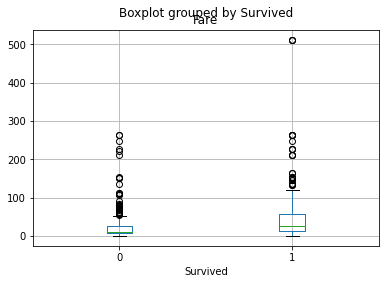

In [ ]:
training_data.boxplot('Fare', 'Survived')

### Survived

In [ ]:
training_data['Survived'].value_counts() / len(training_data)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

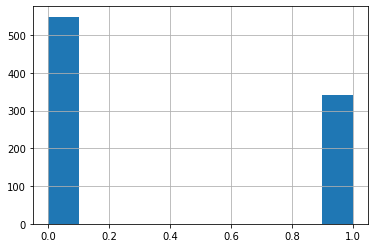

In [ ]:
training_data['Survived'].hist()

The distribution of the _Survived_ attribute tells us that 61.6% of passengers died, so only the 38.38% survived

### Sex

In [ ]:
training_data['Sex'].value_counts() / len(training_data)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

The 64% of passengers were males, whereas the 35% were females, let's review these statistics among survivors and non-survivors

In [ ]:
training_data[training_data['Survived'] == 0]['Sex'].value_counts() / len(training_data[training_data['Survived'] == 0])

male      0.852459
female    0.147541
Name: Sex, dtype: float64

Among the non-survivors, 85.24% were men, while 14% were women, so they prioritized saving women over men.

In [ ]:
training_data[training_data['Survived'] == 1]['Sex'].value_counts() / len(training_data[training_data['Survived'] == 1])

female    0.681287
male      0.318713
Name: Sex, dtype: float64

The females still are the majority among the survivors, being a 68% of survivors women. The 31% were men.

Also we could check if the class of the women that did not survive, to see if they were rich or poor.



### Ticket

In [ ]:
training_data['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

This attribute does not seem to be of much use, it has 681 unique values so it has a large variance. The only way it could be helpful would be if we would know some way to identify expensive tickets from the inexpensive ones.

In [ ]:
training_data[training_data['Pclass'] == 1]['Ticket'].head(20)

1        PC 17599
3          113803
6           17463
11         113783
23         113788
27          19950
30       PC 17601
31       PC 17569
34       PC 17604
35         113789
52       PC 17572
54         113509
55          19947
61         113572
62          36973
64       PC 17605
83         113059
88          19950
92    W.E.P. 5734
96       PC 17754
Name: Ticket, dtype: object

We could review that 1st class tickets starts with a 1, 2nd class with a 2 and 3rd class with a 3.

### Cabin

In [ ]:
training_data['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

### Embarked

In [ ]:
training_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

It has 3 unique values so let's check it distributions

In [ ]:
training_data['Embarked'].value_counts() / len(training_data)

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

In [ ]:
training_data[training_data['Survived'] == 0]['Embarked'].value_counts() / len(training_data[training_data['Survived'] == 0])

S    0.777778
C    0.136612
Q    0.085610
Name: Embarked, dtype: float64

In [ ]:
training_data[training_data['Survived'] == 1]['Embarked'].value_counts() / len(training_data[training_data['Survived'] == 1])

S    0.634503
C    0.271930
Q    0.087719
Name: Embarked, dtype: float64

There is not clear evidence that passengers that embarked for a certaing city are more likly to die. It maintains the same distribution of ports among survivors and non-survivors.

## Missing Values and Outliers

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are three attibutes containing missing values:
- _Age_ has a 19.86% of missing values
- _Cabin_ has a 77.1% of missing values
- _Embarked_ has a 0.2% of missing values

So we are going to **impute the values on _Age_ and _Embarked_** and also we are going to **remove the _Cabin_ attribute** due to the high percentage of missing values.

## Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f3b79f438>,
      dtype=object)

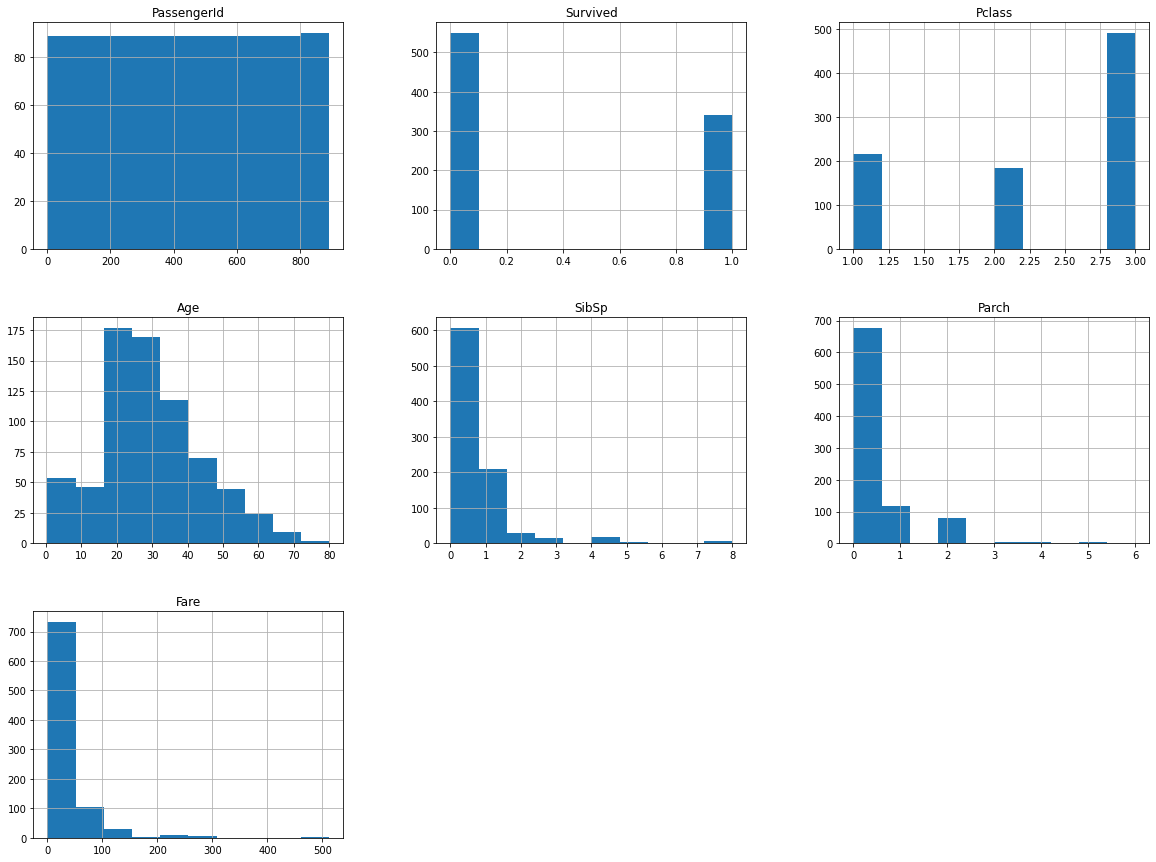

In [31]:
training_data.hist(figsize=(20,15))

## Correlations

In [ ]:
corr_matrix = training_data.corr()

In [ ]:
corr_matrix['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

Most significative correlations:
- As the _Pclass_ goes down, the _Survived_ goes up. That makes sense with the previous assumptions in which the passengers from 1st class were more likely to survive.
- As the _Fare_ goes up, the Survived goes up too. So the higher the fare the more likely to survive.

Later we will convert the categorical variables _Sex_ and _Embarked_ into numeric ones and then we will check the correlation again.

## Possible feature transformations
With the previous assumptions these are a few ideas to make in future steps:
- Remove the _Cabin_ column because it has a high percentage of missing values and it does not provide useful information
- Create age categories (childs, teenagers, young adults, adults, old people)
- Remove the _Ticket_ attribute because is a categorical variable with great variance.
- Create an attribute that relates _Fare_ and _PClass_
- Create an attribute that contains all the family relations
- Create an attribute that relates the family relations and the _PClass_
- Maybe detect some titles in the passenger's names (like Sir, Mr, etc...)

# Data Preparation

## Handling missing values

In [12]:
class RemoveAttributes(BaseEstimator, TransformerMixin):

    def __init__(self, attributes: List[str]) -> None:
        self.attributes = attributes

    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None) -> object:
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        transformed_df = X.drop(self.attributes, axis=1)

        return transformed_df

**WARNING**: Transformer attributes cannot start with an undersocre '_' if we want to use the transformer in a Pipeline

In [ ]:
remove_attributes = RemoveAttributes(['Cabin', 'Ticket'])
training_data = remove_attributes.fit_transform(training_data)

In [ ]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [ ]:
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

In [ ]:
training_data_num = training_data[['Age']]
training_data_cat = training_data[['Embarked']]

In [ ]:
training_data_num_fixed = imputer_num.fit_transform(training_data_num)

In [ ]:
training_data_cat_fixed = imputer_cat.fit_transform(training_data_cat)

In [ ]:
training_data = training_data.drop(['Age', 'Embarked'], axis=1)

In [ ]:
training_data['Age'] = training_data_num_fixed
training_data['Embarked'] = training_data_cat_fixed

## Convert categoric attributes to ordinal

In [ ]:
ordinal_encoder = OrdinalEncoder()
training_data_cat = training_data[['Sex', 'Embarked']]

In [ ]:
training_data_cat_encoded = ordinal_encoder.fit_transform(training_data_cat)

In [ ]:
training_data['Sex'] = training_data_cat_encoded[:, 0]

In [ ]:
training_data['Embarked'] = training_data_cat_encoded[:, 1]

In [ ]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Age,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1.0,1,0,7.2500,22.0,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,1,0,71.2833,38.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,0,0,7.9250,26.0,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,1,0,53.1000,35.0,2.0
4,5,0,3,"Allen, Mr. William Henry",1.0,0,0,8.0500,35.0,2.0


In [ ]:
ordinal_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

## Checking correlations again

In [ ]:
training_data.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex           -0.543351
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Age           -0.064910
Embarked      -0.167675
Name: Survived, dtype: float64

The _Sex_ attribute is higly negative correlated with the survivors, being 1=Male and 0=Female. So when the _Sex_ goes down (females) the _Survived_ value goes up`(Survived), so it makes sense with our previous assumptions.  
The _Embarked_ (C=0, Q=1, S=2) attribute is also negative correlated, so when it goes down (C or Q ports), the _Survived_ value goes up.

## Feature Engineering
- Create age categories (childs, teenagers, young adults, adults, old people)
- Create an attribute that relates _Fare_ and _PClass_
- Create an attribute that contains all the family relations
- Create an attribute that relates the family relations and the _PClass_
- Maybe detect some titles in the passenger's names (like Sir, Mr, etc...)

In [76]:
class AgeCategoriesAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, age_index: int) -> None:
        self.age_index = age_index
        self.bins = np.array([0.0, 14.0, 21.0, 27.0, 49.0, 100.])
    
    def fit(self, X: np.ndarray, y: np.ndarray=None) -> object:
        return self

    def transform(self, X: np.ndarray):
        age_categories = pd.cut(X[:, self.age_index], bins=self.bins,
                                labels=[1, 2, 3, 4, 5])
 
        return np.c_[X, age_categories]

class ClassFareAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, pclass_idx: int, fare_idx: int) -> None:
        self.pclass_idx, self.fare_idx = pclass_idx, fare_idx

    def fit(self, X: np.ndarray, y: np.ndarray=None) -> object:
        return self

    def transform(self, X: np.ndarray):
        class_fare_relation = np.divide(X[:, self.fare_idx], (X[:, self.pclass_idx] + 1.))**2

        return np.c_[X, class_fare_relation]

class FamilyRelationsAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, sibsp_ix, parch_idx) -> None:
        self.sibsp_idx, self.parch_idx = sibsp_ix, parch_idx

    def fit(self, X: np.ndarray, y: np.ndarray=None) -> object:
        return self

    def transform(self, X: np.ndarray):
        relations = X[:, self.sibsp_idx] + X[:, self.parch_idx]

        return np.c_[X, relations]

class ClassFamilyAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, sibsp_idx, parch_idx, pclass_idx) -> None:
        self.sibsp_idx, self.parch_idx, self.pclass_idx = sibsp_idx, parch_idx, pclass_idx

    def fit(self, X: np.ndarray, y: np.ndarray=None) -> object:
        return self

    def transform(self, X: np.ndarray):
        relations = X[:, self.sibsp_idx] + X[:, self.parch_idx]
        class_family = np.divide(relations, (X[:, self.pclass_idx] + 1.))**2

        return np.c_[X, class_family]

## Transformation Pipelines

In [77]:
y_train = training_data['Survived'].to_numpy()
X_train = training_data.drop('Survived', axis=1)

In [78]:
num_pipeline = Pipeline([
                     ('num_imputer', SimpleImputer(strategy='median'))
])

In [79]:
cat_pipeline = Pipeline([
                         ('remove_cat_attributes', RemoveAttributes(attributes=['Cabin', 'Ticket', 'Name', 'PassengerId'])),
                         ('cat_imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OrdinalEncoder())
])

In [80]:
preparation_pipeline = ColumnTransformer([
                                   ('numeric', num_pipeline, ['Age', 'SibSp', 'Parch', 'Fare']),
                                   ('categorical', cat_pipeline, ['PassengerId', 'Pclass', 'Name', 'Sex', 'Cabin', 'Ticket', 'Embarked'])
])

full_pipeline = Pipeline([
                          ('prep_pipeline', preparation_pipeline),
                          ('age_cat_attribute', AgeCategoriesAttribute(0)),
                          ('class_fare_attribute', ClassFareAttribute(3, 4)),
                          ('family_relations_attribute', FamilyRelationsAttribute(1, 2)),
                          ('class_family_attribute', ClassFamilyAttribute(1, 2, 4)),
                          ('scaler', StandardScaler())
])

In [81]:
X_train_transformed = full_pipeline.fit_transform(X_train)

In [83]:
X_train_transformed

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.04624474,
         0.05915988, -0.28473128],
       [ 0.66386103,  0.43279337, -0.47367361, ..., -0.16488951,
         0.05915988,  0.08848765],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.01551614,
        -0.56097483, -0.33138365],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ..., -0.14085093,
         1.29942929,  0.08848765],
       [-0.25833709, -0.4745452 , -0.47367361, ..., -0.16488951,
        -0.56097483, -0.33138365],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.02280453,
        -0.56097483, -0.33138365]])

# Models

## Dummy Classifier
We are going to build a baseline classifier that returns the passenger did not survive in all the cases

In [ ]:
target = training_data['Survived'].to_numpy()
data = training_data.drop('Survived', axis=1)
data = data.to_numpy()

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')

In [ ]:
dummy_clf.fit(data, target)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [ ]:
y_pred = dummy_clf.predict(data)
accuracy_score(target, y_pred)

0.6161616161616161

So for our model to be useful, **it must surpass a 61% of accuracy**

## SGD Classifier

In [84]:
sgd_clf = SGDClassifier()

sgd_clf.fit(X_train_transformed, y_train)
y_pred_training = sgd_clf.predict(X_train_transformed)
sgd_training_acc = accuracy_score(y_train, y_pred_training)

sgd_acc_val = cross_val_score(sgd_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
sgd_acc_val = np.mean(sgd_acc_val)

print(f'Training accuracy: {sgd_training_acc}')
print(f'Validation accuracy: {sgd_acc_val}')

Training accuracy: 0.7418630751964085
Validation accuracy: 0.69917142677798


## K-NN

In [85]:
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_transformed, y_train)
y_pred_training = knn_clf.predict(X_train_transformed)
knn_training_acc = accuracy_score(y_train, y_pred_training)

knn_acc_val = cross_val_score(knn_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
knn_acc_val = np.mean(knn_acc_val)

print(f'Training accuracy: {knn_training_acc}')
print(f'Validation accuracy: {knn_acc_val}')

Training accuracy: 0.856341189674523
Validation accuracy: 0.8036093151716779


## Bayes

In [86]:
bayes_clf = GaussianNB()

bayes_clf.fit(X_train_transformed, y_train)
y_pred_training = bayes_clf.predict(X_train_transformed)
bayes_training_acc = accuracy_score(y_train, y_pred_training)

bayes_acc_val = cross_val_score(bayes_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
bayes_acc_val = np.mean(bayes_acc_val)

print(f'Training accuracy: {bayes_training_acc}')
print(f'Validation accuracy: {bayes_acc_val}')

Training accuracy: 0.792368125701459
Validation accuracy: 0.7598204758018958


## Decision Tree

In [87]:
decision_clf = DecisionTreeClassifier()

decision_clf.fit(X_train_transformed, y_train)
y_pred_training = decision_clf.predict(X_train_transformed)
decision_training_acc = accuracy_score(y_train, y_pred_training)

decision_acc_val = cross_val_score(decision_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
decision_acc_val = np.mean(decision_acc_val)

print(f'Training accuracy: {decision_training_acc}')
print(f'Validation accuracy: {decision_acc_val}')

Training accuracy: 0.9797979797979798
Validation accuracy: 0.7811687904086373


## Random Forest

In [88]:
forest_clf = RandomForestClassifier()

forest_clf.fit(X_train_transformed, y_train)
y_pred_training = forest_clf.predict(X_train_transformed)
forest_training_acc = accuracy_score(y_train, y_pred_training)

forest_acc_val = cross_val_score(forest_clf, X_train_transformed, y_train, cv=5, scoring='accuracy')
forest_acc_val = np.mean(forest_acc_val)

print(f'Training accuracy: {forest_training_acc}')
print(f'Validation accuracy: {forest_acc_val}')

Training accuracy: 0.9797979797979798
Validation accuracy: 0.8114995919904588


In [100]:
param_grid = {
            'bootstrap': [False, True],
            'n_estimators': [100, 120, 140, 160, 180, 200, 220],
            'max_features': [2, 4, 6, 8, 11],
            'max_depth': [2, 4, 6, 8, 10]
            }

In [101]:
forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [102]:
results = grid_search.cv_results_

for mean_test, mean_train, params in zip(results['mean_test_score'], results['mean_train_score'], results['params']):
    print(f'Mean_test: {mean_test}, Mean_train:{mean_train}, Params:{params}')

Mean_test: 0.771156863975896, Mean_train:0.7954512504530628, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
Mean_test: 0.7621869311405437, Mean_train:0.7890012134201113, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 120}
Mean_test: 0.762174377000816, Mean_train:0.7803043793434924, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 140}
Mean_test: 0.7767685644341221, Mean_train:0.7892805364262414, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 160}
Mean_test: 0.7722804594815139, Mean_train:0.792928282143814, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 180}
Mean_test: 0.7632979725064339, Mean_train:0.7934869281560742, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n_estimators': 200}
Mean_test: 0.7700332684702781, Mean_train:0.7901220511527491, Params:{'bootstrap': False, 'max_depth': 2, 'max_features': 2, 'n

In [106]:
results['mean_test_score'][np.argmax(results['mean_test_score'])], results['mean_train_score'][np.argmax(results['mean_test_score'])], results['params'][np.argmax(results['mean_test_score'])]

(0.8417927311530977,
 0.9250843090596781,
 {'bootstrap': True, 'max_depth': 8, 'max_features': 8, 'n_estimators': 200})

# Submision

In [107]:
final_model = grid_search.best_estimator_

In [108]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [109]:
ids = X_test['PassengerId']
X_test_transformed = full_pipeline.fit_transform(X_test)

In [111]:
y_pred = final_model.predict(X_test_transformed)

In [112]:
len(y_pred), len(ids)

(418, 418)

In [113]:
submission_data = np.c_[ids, y_pred]

In [114]:
submission_df = pd.DataFrame(submission_data, columns=['PassengerId', 'Survived'])

In [115]:
submission_df.to_csv('random_forest_84_accuracy.csv', index=False)